#### Transfer Learning Modell 2
- Backbone VGG-16
- Images cropped and resized
- Colorscheme: Substract local average color from each pixel

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

In [3]:
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

In [4]:
import tensorflow as tf

In [5]:
df = pd.read_csv(r'D:\data\Projects\notebooks\RetinaAI\03_ Multiclass\Datasets\train4_small.csv')

In [8]:
df.head()

,filename,labels
0,3f58d128caf6.jpg,glaucoma
1,802b4bfabd52.jpg,md
2,7bcfab1fa2da.jpg,opacity
3,012e91949ec4.jpg,opacity
4,6386346fb595.jpg,opacity


In [9]:
# Original Images
in_dir = r'D:\data\Projects\notebooks\RetinaAI\03_ Multiclass\Datasets\four_var3'

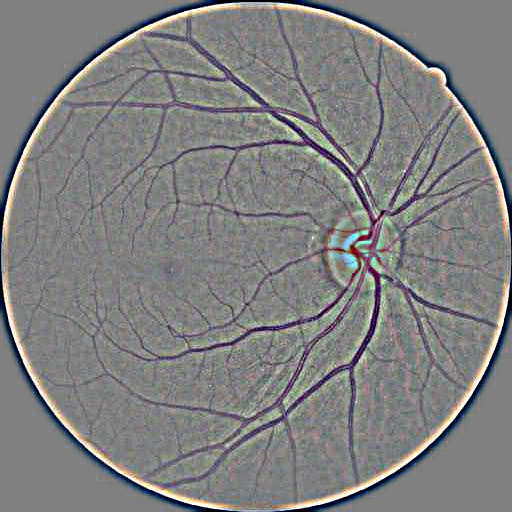

In [10]:
display(Image(in_dir+'\\'+df.filename[0]))

### Image Generator

In [11]:
datagen = ImageDataGenerator(rescale=1./255.)

In [12]:
train_gen = datagen.flow_from_dataframe(dataframe = df[:1500], 
                                            directory = in_dir, 
                                            x_col = "filename", 
                                            y_col = 'labels',
                                            batch_size = 10, 
                                            seed = 2, 
                                            shuffle = True, 
                                            class_mode = "categorical", 
                                            classes = ['opacity', 'glaucoma','md', 'normal'],
                                            target_size = (224,224))

Found 1500 validated image filenames belonging to 4 classes.


In [13]:
val_gen = datagen.flow_from_dataframe(dataframe = df[1500:], 
                                            directory = in_dir, 
                                            x_col = "filename", 
                                            y_col = 'labels',
                                            batch_size = 10, 
                                            seed = 2, 
                                            shuffle = False,#Labels nicht shuffeln für CM 
                                            class_mode = "categorical", 
                                            classes = ['opacity', 'glaucoma','md', 'normal'],
                                            target_size = (224,224))

Found 500 validated image filenames belonging to 4 classes.


In [14]:
imgs, labels = next(train_gen)

In [15]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    

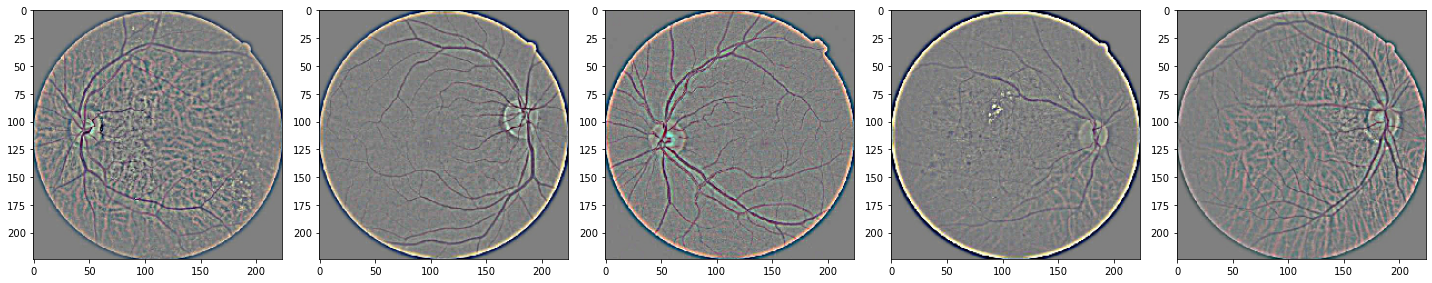

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [16]:
plotImages(imgs)
print(labels)

### Model

In [17]:
model_vgg16 = tf.keras.applications.vgg16.VGG16()

In [18]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
model = Sequential()
for layer in model_vgg16.layers[:-1]:
    model.add(layer)

In [20]:
for layer in model.layers:
    layer.trainable = False

In [21]:
model.add(Dense(units=4, activation='softmax'))

In [22]:
step_size_train = train_gen.n//train_gen.batch_size
step_size_val = val_gen.n//val_gen.batch_size

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
history = model.fit(x=train_gen, validation_data=val_gen, steps_per_epoch=step_size_train, 
          validation_steps=step_size_val, epochs=10,verbose=2)

Epoch 1/10
150/150 - 2047s - loss: 1.3712 - accuracy: 0.4053 - val_loss: 1.0813 - val_accuracy: 0.4820
Epoch 2/10
150/150 - 2042s - loss: 1.1104 - accuracy: 0.5187 - val_loss: 0.8655 - val_accuracy: 0.6540
Epoch 3/10
150/150 - 2015s - loss: 1.0851 - accuracy: 0.5567 - val_loss: 1.7282 - val_accuracy: 0.4580
Epoch 4/10
150/150 - 2047s - loss: 0.9786 - accuracy: 0.5900 - val_loss: 1.2630 - val_accuracy: 0.4080
Epoch 5/10
150/150 - 2055s - loss: 0.9598 - accuracy: 0.5967 - val_loss: 1.0267 - val_accuracy: 0.5420
Epoch 6/10
150/150 - 2032s - loss: 0.9228 - accuracy: 0.5960 - val_loss: 1.1116 - val_accuracy: 0.4880
Epoch 7/10
150/150 - 2010s - loss: 0.9019 - accuracy: 0.6133 - val_loss: 0.6354 - val_accuracy: 0.7320
Epoch 8/10
150/150 - 1973s - loss: 0.9238 - accuracy: 0.6180 - val_loss: 1.1358 - val_accuracy: 0.4720
Epoch 9/10
150/150 - 1967s - loss: 0.8724 - accuracy: 0.6287 - val_loss: 0.9525 - val_accuracy: 0.5880
Epoch 10/10
150/150 - 1980s - loss: 0.8826 - accuracy: 0.6313 - val_loss:

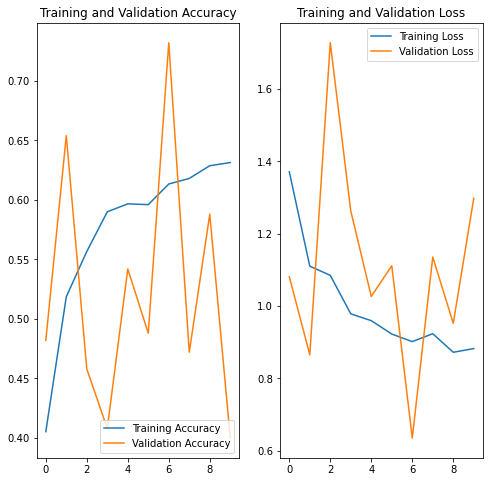

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()